In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 파라미터

In [2]:
IMAGE_SIZE = (64, 64)  # 이미지 크기
BATCH_SIZE = 32
EPOCHS = 50

### 1. 데이터 준비

In [3]:
labels = pd.read_csv('labels.csv')
images = []
y = []

for _, row in labels.iterrows():
    img_path = os.path.join('data', row['filename'])
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img = img_to_array(img) / 255.0
    images.append(img)
    y.append(row['label'])

X = np.array(images) # 이미지 데이터
y = np.array(y) # 종류

### 2. 라벨 인코딩 및 train/test 분리

In [4]:
encoder   = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_onehot    = to_categorical(y_encoded, num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42
)

In [5]:
X_full = X
y_full = y_onehot

### 3. 데이터 증강

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30, # 0 ~ 30도 회전
    width_shift_range=0.1, # 좌우 0~10% 이동
    height_shift_range=0.1, # 상하 0~10% 이동
    horizontal_flip=False,
    vertical_flip=False,
)

test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [8]:
full_generator = train_datagen.flow(
    X_full, y_full,
    batch_size=BATCH_SIZE,
    shuffle=True
)

### 4. 모델 구성

In [9]:
def build_cnn(input_shape=(64, 64, 3), classes=num_classes):
    my_model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(classes, activation='softmax')
    ])
    return my_model

model = build_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                        

2025-06-19 23:00:50.985791: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-19 23:00:50.985813: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-19 23:00:50.985818: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-19 23:00:50.985843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-19 23:00:50.985853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 5. 모델 구조 출력 및 저장

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [11]:
os.makedirs('output', exist_ok=True)
early_cb = EarlyStopping(monitor='val_accuracy', patience=5,
                         restore_best_weights=True)
ckpt_cb  = ModelCheckpoint('output/leesanghyun.h5', monitor='val_loss',
                           save_best_only=True, verbose=1)

### 6. 학습

In [ ]:
history = model.fit(
    full_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_cb, ckpt_cb],
    verbose=2
)

Epoch 1/50


2025-06-19 23:00:51.399003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-19 23:00:51.411823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-06-19 23:00:51.417544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-06-19 23:00:55.051116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-19 23:00:55.056501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-06-19 23:00:55.058868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deseria


Epoch 1: val_loss improved from inf to 3.66806, saving model to output/leesanghyun.h5
229/229 - 4s - loss: 4.2574 - accuracy: 0.0599 - val_loss: 3.6681 - val_accuracy: 0.1379 - 4s/epoch - 19ms/step
Epoch 2/50


/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 3.66806 to 3.18513, saving model to output/leesanghyun.h5
229/229 - 4s - loss: 3.6383 - accuracy: 0.1310 - val_loss: 3.1851 - val_accuracy: 0.2314 - 4s/epoch - 16ms/step
Epoch 3/50

Epoch 3: val_loss improved from 3.18513 to 2.81249, saving model to output/leesanghyun.h5
229/229 - 4s - loss: 3.2565 - accuracy: 0.1936 - val_loss: 2.8125 - val_accuracy: 0.2901 - 4s/epoch - 16ms/step
Epoch 4/50


### 7. Loss/Accuracy 그래프

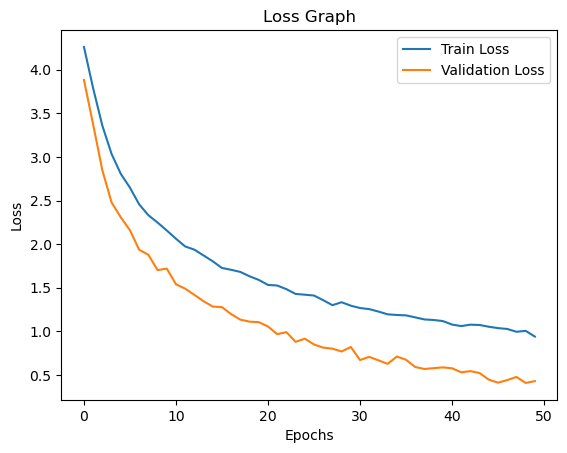

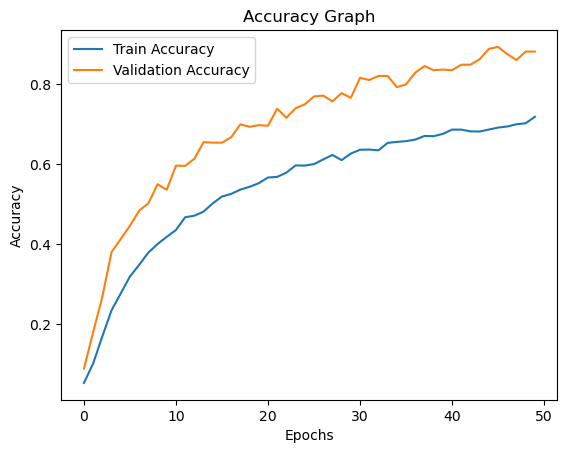

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 8. 평가 및 오분류 샘플 분석

In [14]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=0)
print(f"\n테스트 accuracy = {test_acc:.4f} | loss = {test_loss:.4f}")


테스트 accuracy = 0.8805 | loss = 0.4287


30/46 [==================>...........] - ETA: 0s

2025-06-19 22:57:24.539451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-19 22:57:24.543153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-06-19 22:57:24.545235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


46/46 [==============================] - 0s 6ms/step


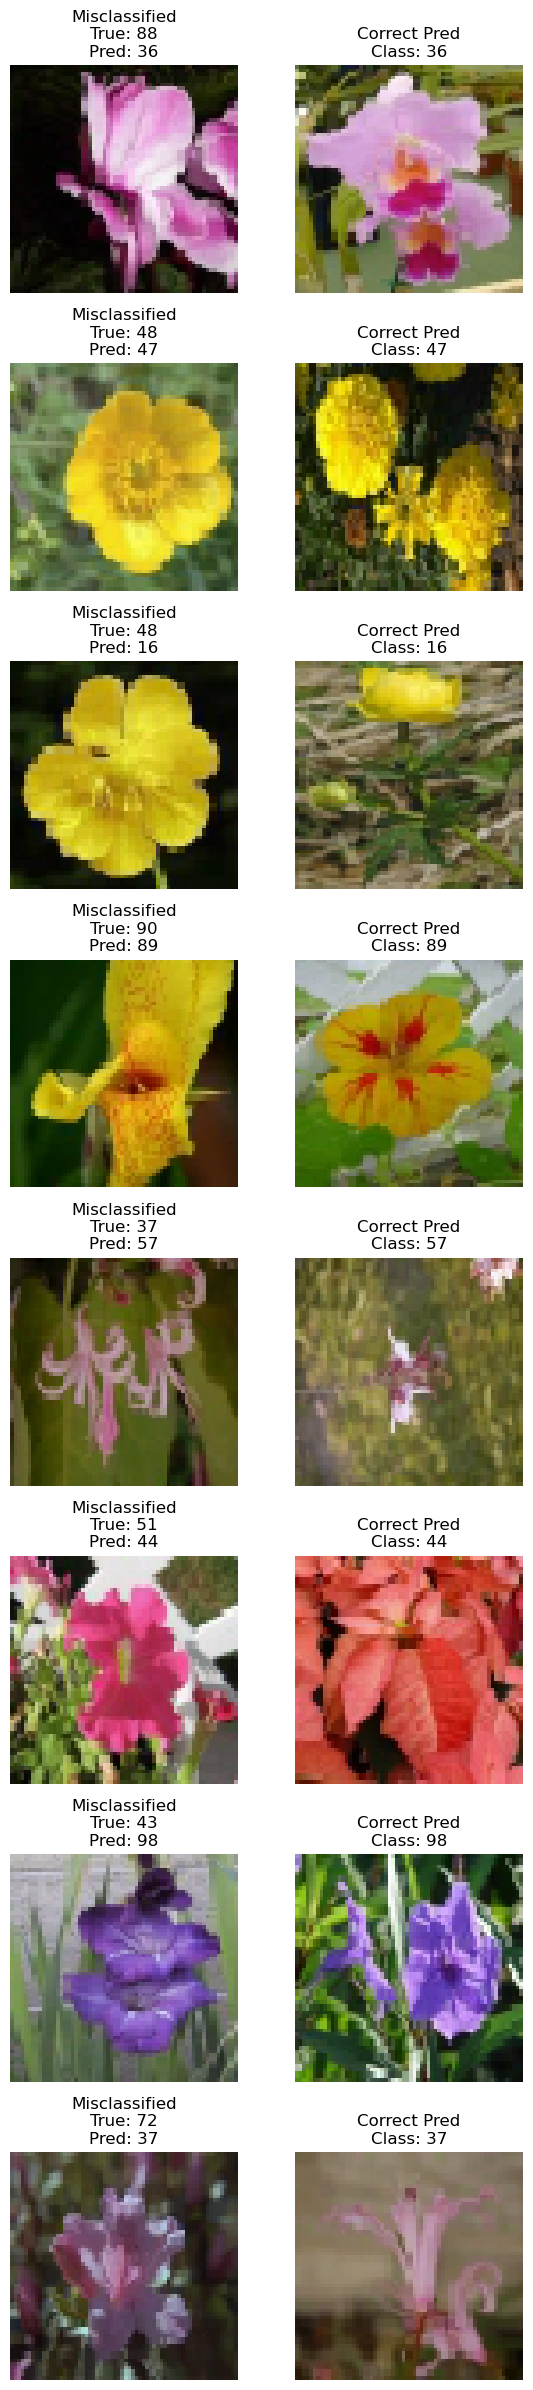

In [15]:
import matplotlib.pyplot as plt
import numpy as np

PRINT_COUNT = 8

X_imgs = X_test
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_imgs), axis=1)
mis_idx = np.where(y_pred != y_true)[0]
sel = mis_idx[:PRINT_COUNT]

fig, axes = plt.subplots(len(sel), 2, figsize=(6, len(sel)*3))

for i, idx in enumerate(sel):
    true_lbl = encoder.classes_[y_true[idx]]
    pred_lbl = encoder.classes_[y_pred[idx]]

    # 잘못 분류된 이미지
    ax0 = axes[i, 0]
    ax0.imshow(X_imgs[idx])
    ax0.set_title(f"Misclassified\nTrue: {true_lbl}\nPred: {pred_lbl}")
    ax0.axis('off')

    # 예측된 Pred 클래스의 올바른 예시
    correct_pred = np.where((y_true == y_pred[idx]) & (y_pred == y_pred[idx]))[0]
    ax1 = axes[i, 1]
    if len(correct_pred) > 0:
        ax1.imshow(X_imgs[correct_pred[0]])
        ax1.set_title(f"Correct Pred\nClass: {pred_lbl}")
    ax1.axis('off')

plt.tight_layout()
plt.show()